In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gpaw import GPAW
from abtem.dft import GPAWPotential
from ase.io import read
from abtem import *

# *ab initio* potentials with GPAW

The independent atom model (IAM) neglects any effects due to bonding and charge transfer. However, since the nucleus and core electrons constitute most of the charge in an atom, this is often a good approximation. Nonetheless, the difference between the IAM and a more realistic model including the effects of bonding is measurable, at least in certain systems. This difference can obviously be important, since it contains all the chemistry of the system.

Here we go beyond the independent atom model using density functional theory (DFT). Note that you need a working GPAW installation for this tutorial, see the [GPAW documentation](https://wiki.fysik.dtu.dk/gpaw/) for more information.

## DFT calculation

The first step in for creating a DFT potential is to converge a DFT calculation.

The unit cell for the DFT calculation does not have to be orthogonal, but the potential has to be made orthogonal before the multislice simulation. Only unit cells that can be thought of as an extruded parallelogram are thus allowed. If `standardize_cell` raises an error, abTEM is unable to use the DFT calculation.

We will use the minimal hexagonal cell for our graphene DFT calculation.

In [2]:
atoms = read('data/hexagonal_graphene.cif')

To run the DFT calculation, we use the `GPAW` calculator object. We set its real-space grid spacing to a small value of 0.1 Å and use a k-point grid of (3,3,1). The DFT real-space grid does not have to match the grid used in the multislice simulations.

Running the method `.get_potential_energy` triggers the DFT self-consistent field cycle to run, resulting in the `GPAW` object now containing the converged PAW electron density.

In [3]:
gpaw = GPAW(h=.1, txt=None, kpts=(3,3,1))
atoms.calc = gpaw
atoms.get_potential_energy()

-19.68456129990072

DFT calculations can be extremely computationally intensive, and may require massive parallelization. Running such simulations in a notebook is generally not recommended, hence, running the DFT calculation separately, and importing the GPAW calculator for the image simulation is typically a better workflow.

The GPAW object can be written to and read from disk as follows (here supressing GPAW text output on read).

In [4]:
gpaw.write('data/graphene.gpw')

In [5]:
gpaw = GPAW('data/graphene.gpw', txt=None)

## Using the GPAW potential in abTEM

It is straightforward to calculate a DFT potential from a converged GPAW calculation. The `GPAWPotential` object just requires a converged GPAW calculator (containing also the atoms) instead of an `Atoms` object. Note that we can use a finer sampling than was used for the computational grid.

In [7]:
dft_pot = GPAWPotential(gpaw, sampling=.02)

The `.build` method converts the `GPAWPotential` to an `ArrayPotential`, representing the potential as a numpy array. This may be used in image simulations exactly the same way a potential derived from the IAM is used. Here we tile the potential by (3x2) in the $xy$ plane to visualize a larger field of view.

In [8]:
dft_array = dft_pot.build()

dft_potential = dft_array.tile((3,2))

## Comparing DFT to IAM

In [9]:
from abtem.structures import orthogonalize_cell
atoms = orthogonalize_cell(gpaw.atoms) * (3,2,1)

iam_potential = Potential(atoms, gpts=dft_potential.gpts, cutoff_tolerance=1e-4, device='cpu').build()

Note that the zero level of the potential is set to 0 for both the IAM and DFT potentials to facilitate comparison. This makes their calculated relative difference diverge near the atom cores, which is here accounted for by setting diverging values to `nan` and coloring them with grey.

In [10]:
projected_iam = iam_potential.array.sum(0)
projected_iam -= projected_iam.min()

projected_dft = dft_potential.array.sum(0)
projected_dft -= projected_dft.min()

absolute_difference = projected_iam - projected_dft

valid = np.abs(projected_iam) > 1
relative_difference = np.zeros_like(projected_iam)
relative_difference[:] = np.nan
relative_difference[valid] = 100*(projected_iam[valid] - projected_dft[valid]) / projected_iam[valid]

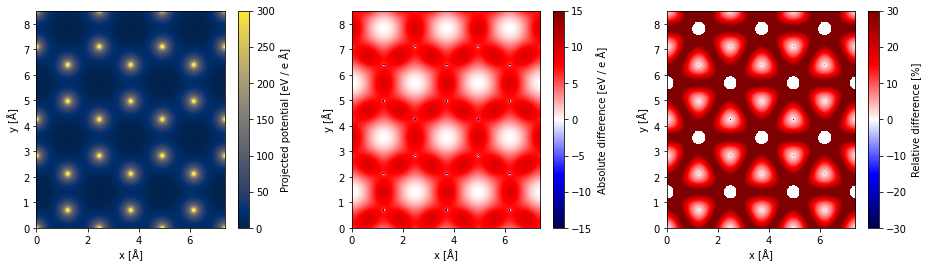

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))

extent = [0, dft_potential.extent[0], 0, dft_potential.extent[1]]

im1 = ax1.imshow(projected_dft.T, cmap='cividis', vmax=300, extent=extent)
im2 = ax2.imshow(absolute_difference.T, vmin=-15, vmax=15, cmap='seismic', extent=extent)
im3 = ax3.imshow(relative_difference.T, vmin=-30, vmax=30, cmap='seismic', extent=extent)

labels = ('Projected potential [eV / e Å]', 'Absolute difference [eV / e Å]', 'Relative difference [%]')

for ax, im, label in zip((ax1, ax2, ax3), (im1, im2, im3), labels):
    ax.set_xlabel('x [Å]')
    ax.set_ylabel('y [Å]')
    
    fig.colorbar(im, ax=ax, label=label)